<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN (Generative Adversarial Networks)

- GAN : https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf

## 1. Load dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_2000.zip -d ./data2000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 18.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 51.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 72.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
From (redirected): https://drive.

## 2. Import python libraries and define util functions

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

In [3]:
set_seed(0)

## 3. Check dataset

In [4]:
path = './data2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [5]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X = []  # initialize empty lists for storing images

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    return X_train, X_test

X_train, X_test = get_data()  # load data set (no y label needed as we only need images) / unsupervised learning

print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (1600, 1, 56, 56)
X_test.shape = (400, 1, 56, 56)


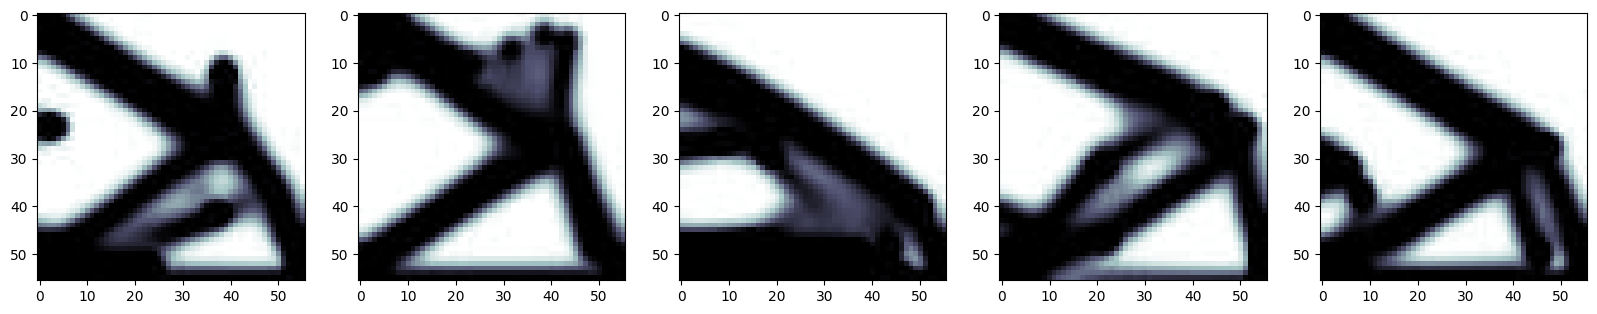

In [6]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
plt.show()

## 5. Set to model architecture

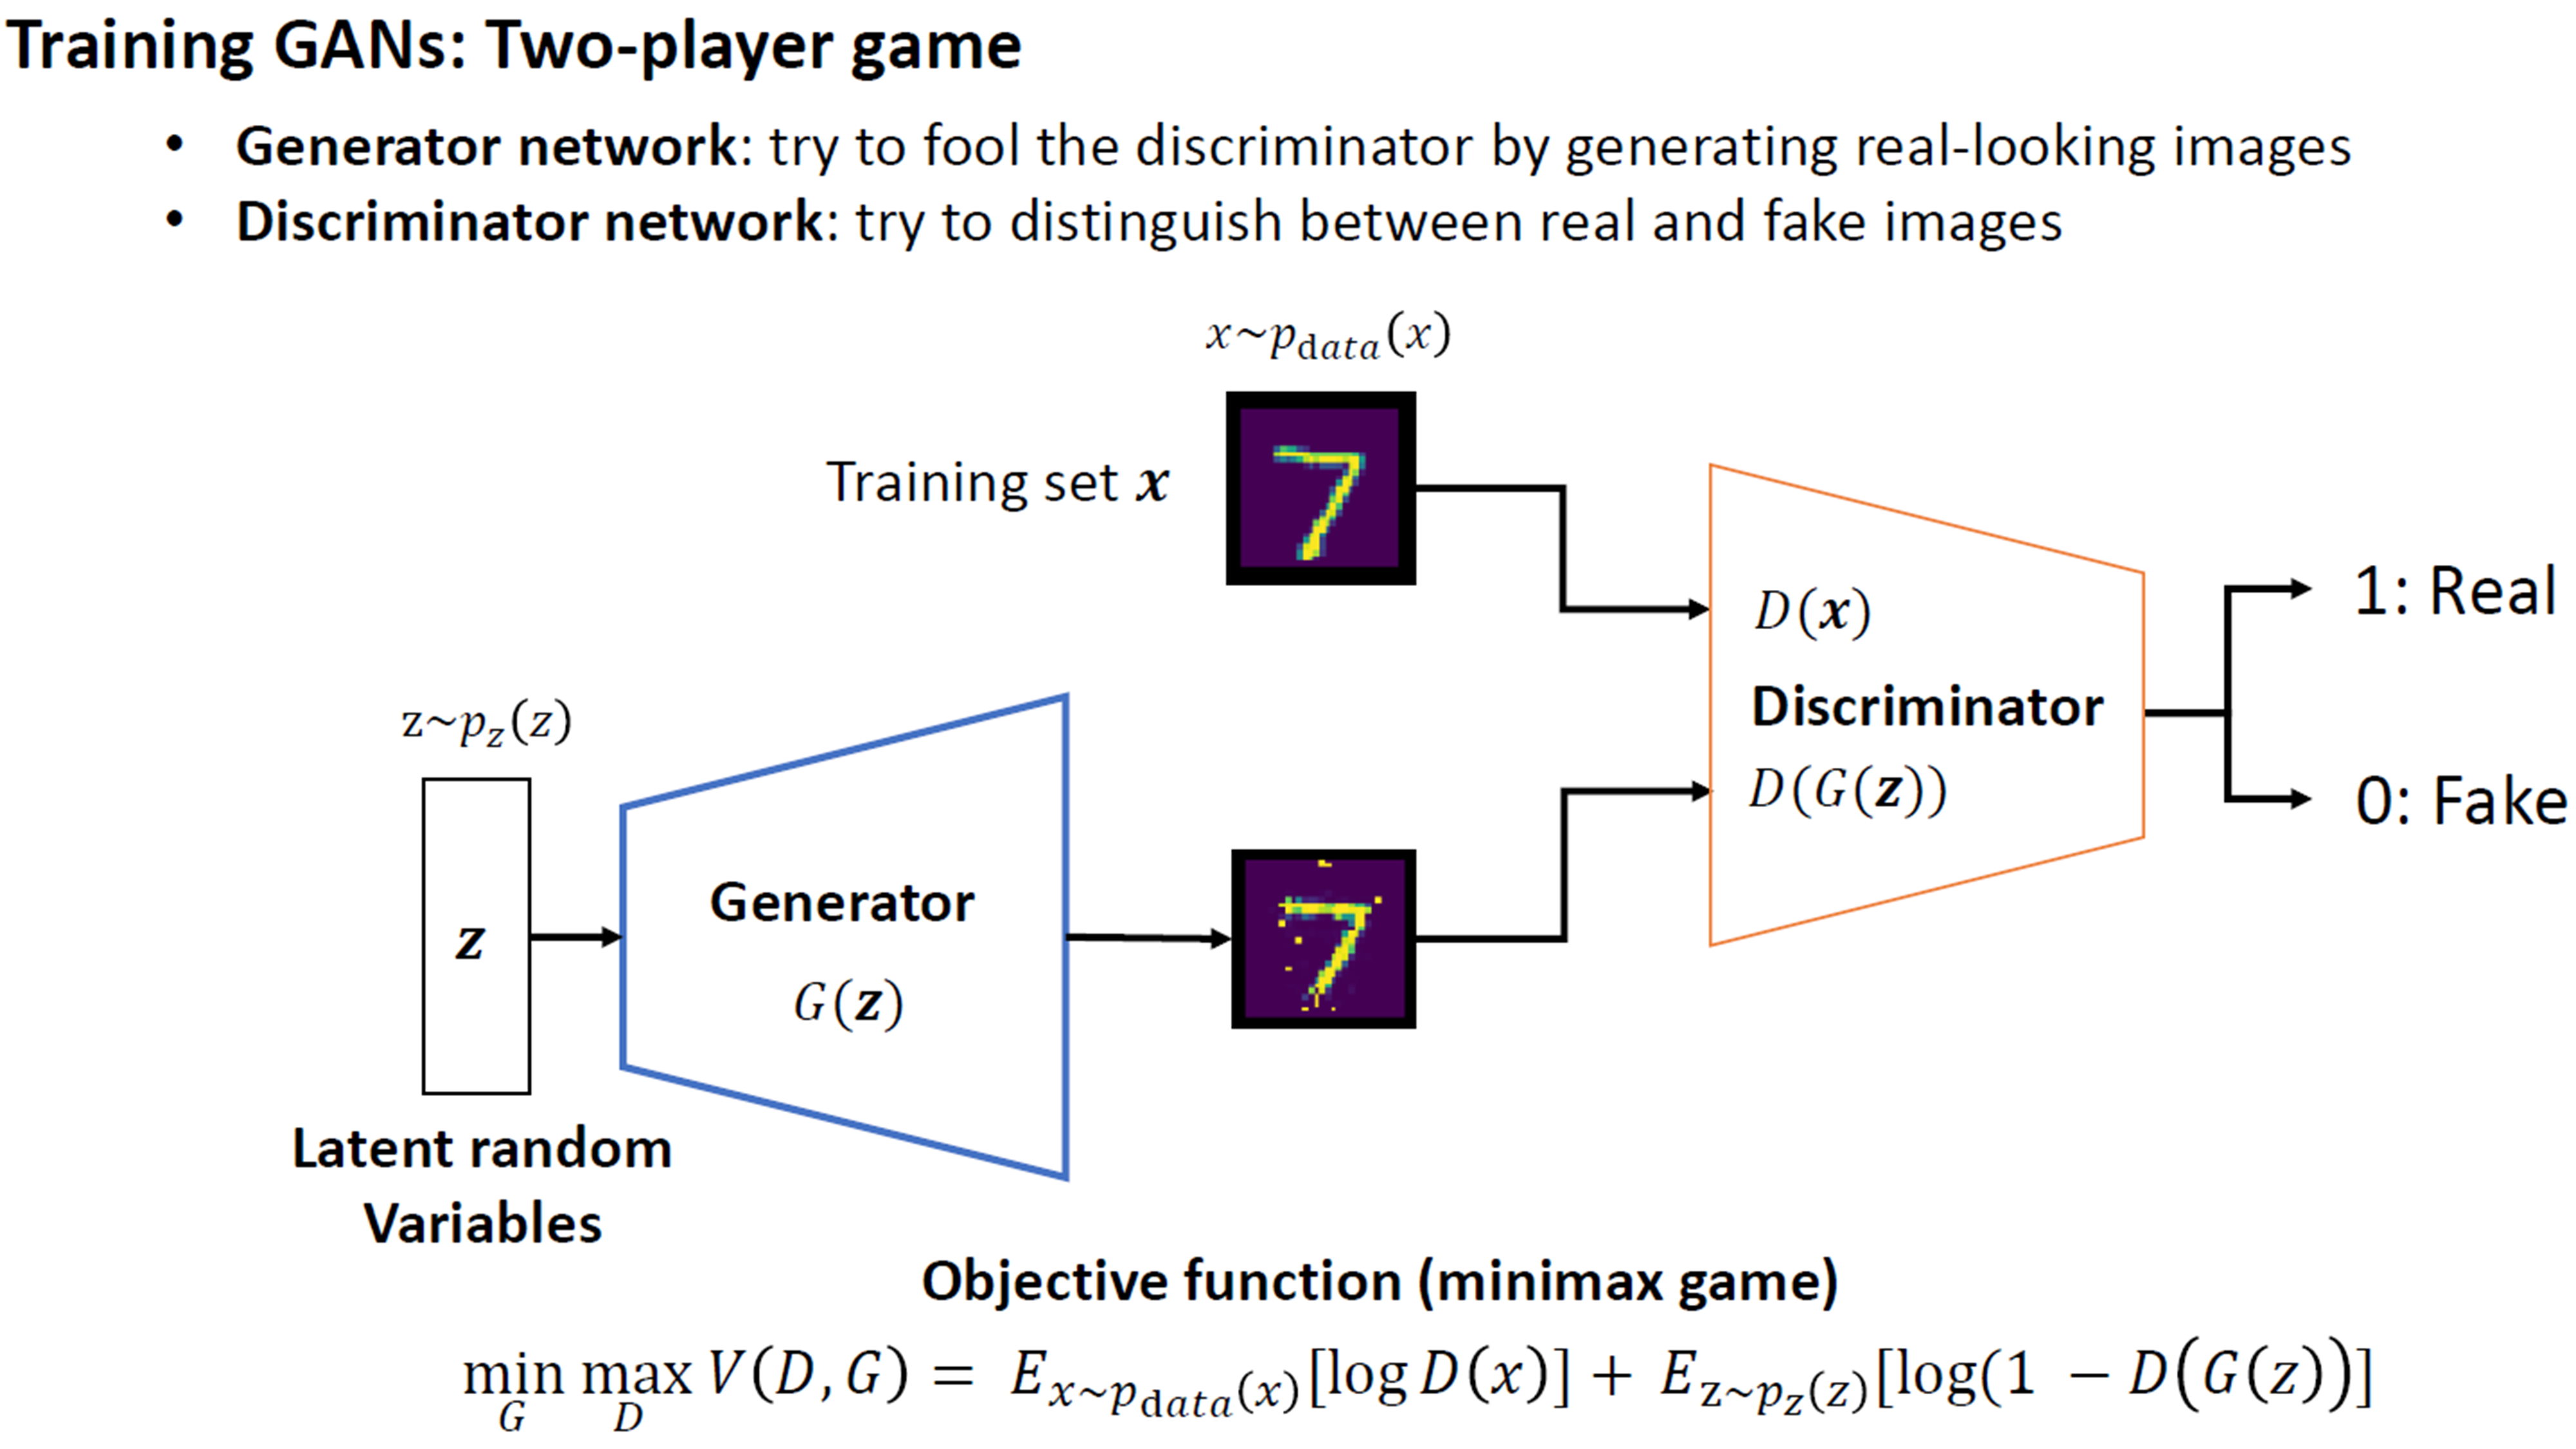

In [7]:
# ---------------------
#  Generator Network (input : noise >> output : image)
# ---------------------

class Generator(nn.Module):  # generate real-looking images
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )

    def forward(self, x):
        gen = self.generator(x)

        return gen

# ---------------------
#  Discriminator Network (input : image >> output : [1 / Real] or [0 / Fake])
# ---------------------

class Discriminator(nn.Module):  # distinguish between real and fake images
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(img_size, hidden_size3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()  # output probability between [0, 1]
        )

    def forward(self, x):
        dis = self.discriminator(x)

        return dis

## 6. Set model hyperparameters

In [8]:
# model architecture parameters
hidden_size1 = 64
hidden_size2 = 256
hidden_size3 = 784
noise_size = 100

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 200

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

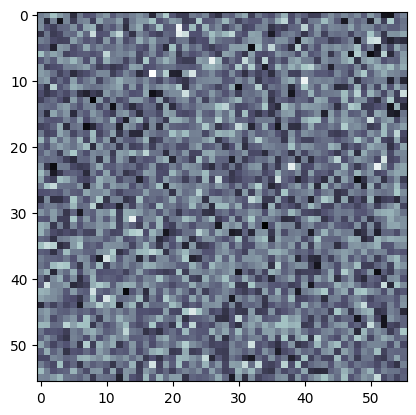

In [9]:
# define networks and set to device (GPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# convert data to PyTorch tensors
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
test_images = torch.tensor(X_test, dtype=torch.float32).to(device)

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.BCELoss() # binary cross entropy loss for binary classification
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# check generated fake bracket image
generated_image = generator(torch.randn([1, 100]).to(device)).cpu().detach()
plt.imshow(torch.reshape(generated_image, (56,56)), cmap=plt.cm.bone)

In [10]:
# define fixed noise for visualization
fixed_noise = torch.randn(10, noise_size).to(device)  # 10 fixed noise vectors

# create a directory to save generated images
os.makedirs("./GAN_samples/", exist_ok=True)

Epoch [1/200]  D Loss: 0.0854  G Loss: 2.4028


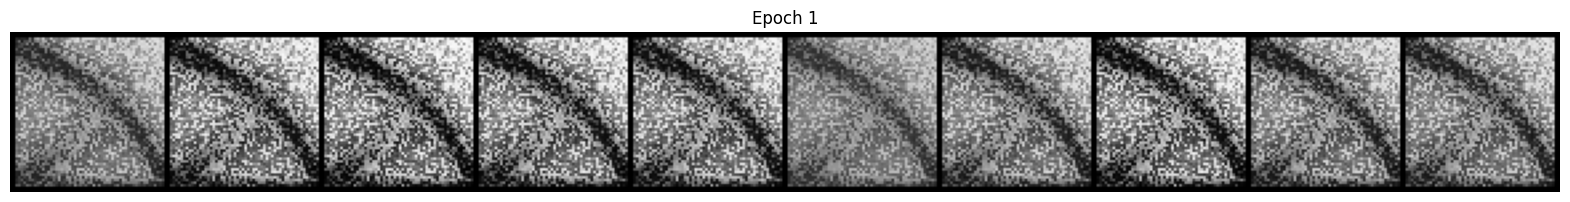

Epoch [2/200]  D Loss: 0.1042  G Loss: 1.8375
Epoch [3/200]  D Loss: 0.0683  G Loss: 2.4723
Epoch [4/200]  D Loss: 0.1049  G Loss: 3.3679
Epoch [5/200]  D Loss: 0.7806  G Loss: 0.5255
Epoch [6/200]  D Loss: 0.0847  G Loss: 3.1190
Epoch [7/200]  D Loss: 0.0529  G Loss: 3.2460
Epoch [8/200]  D Loss: 0.0282  G Loss: 3.9045
Epoch [9/200]  D Loss: 0.1647  G Loss: 1.9913
Epoch [10/200]  D Loss: 0.0289  G Loss: 5.2410
Epoch [11/200]  D Loss: 0.1274  G Loss: 1.9064
Epoch [12/200]  D Loss: 0.2078  G Loss: 1.7517
Epoch [13/200]  D Loss: 0.0308  G Loss: 4.1339
Epoch [14/200]  D Loss: 0.0382  G Loss: 3.0514
Epoch [15/200]  D Loss: 0.2345  G Loss: 1.2937
Epoch [16/200]  D Loss: 0.0240  G Loss: 4.1547
Epoch [17/200]  D Loss: 0.0510  G Loss: 3.3610
Epoch [18/200]  D Loss: 0.0940  G Loss: 6.2160
Epoch [19/200]  D Loss: 0.0293  G Loss: 4.4633
Epoch [20/200]  D Loss: 0.0753  G Loss: 4.9907


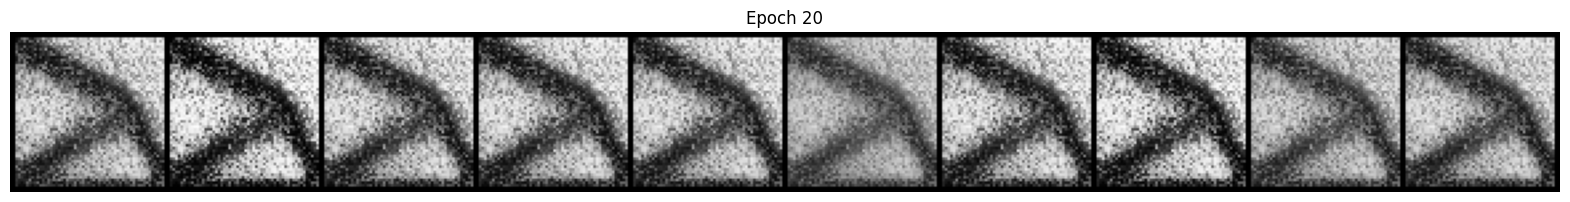

Epoch [21/200]  D Loss: 0.1466  G Loss: 5.7782
Epoch [22/200]  D Loss: 0.0252  G Loss: 4.4254
Epoch [23/200]  D Loss: 0.1775  G Loss: 7.2641
Epoch [24/200]  D Loss: 0.0479  G Loss: 3.1337
Epoch [25/200]  D Loss: 0.0107  G Loss: 4.1193
Epoch [26/200]  D Loss: 0.0644  G Loss: 3.8787
Epoch [27/200]  D Loss: 0.0563  G Loss: 4.3174
Epoch [28/200]  D Loss: 0.0071  G Loss: 5.5524
Epoch [29/200]  D Loss: 0.1603  G Loss: 8.4004
Epoch [30/200]  D Loss: 0.0540  G Loss: 5.1959
Epoch [31/200]  D Loss: 0.0667  G Loss: 3.4531
Epoch [32/200]  D Loss: 0.0230  G Loss: 4.7616
Epoch [33/200]  D Loss: 0.0013  G Loss: 6.7734
Epoch [34/200]  D Loss: 0.0242  G Loss: 3.4175
Epoch [35/200]  D Loss: 0.1497  G Loss: 4.2173
Epoch [36/200]  D Loss: 0.0203  G Loss: 4.4807
Epoch [37/200]  D Loss: 0.0150  G Loss: 4.1323
Epoch [38/200]  D Loss: 0.1180  G Loss: 3.5861
Epoch [39/200]  D Loss: 0.0132  G Loss: 6.2049
Epoch [40/200]  D Loss: 0.0797  G Loss: 3.4568


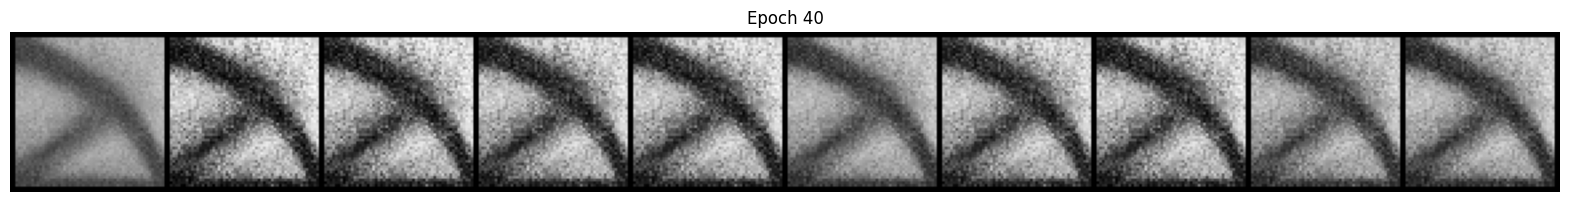

Epoch [41/200]  D Loss: 0.0341  G Loss: 5.4878
Epoch [42/200]  D Loss: 0.2030  G Loss: 8.3314
Epoch [43/200]  D Loss: 0.0285  G Loss: 4.8797
Epoch [44/200]  D Loss: 0.0612  G Loss: 4.6410
Epoch [45/200]  D Loss: 0.0087  G Loss: 6.8701
Epoch [46/200]  D Loss: 0.0695  G Loss: 4.6677
Epoch [47/200]  D Loss: 0.0991  G Loss: 3.9425
Epoch [48/200]  D Loss: 0.0014  G Loss: 9.9531
Epoch [49/200]  D Loss: 0.0124  G Loss: 4.9031
Epoch [50/200]  D Loss: 0.0421  G Loss: 4.4416
Epoch [51/200]  D Loss: 0.0526  G Loss: 7.7364
Epoch [52/200]  D Loss: 0.0126  G Loss: 6.9472
Epoch [53/200]  D Loss: 0.1108  G Loss: 4.1562
Epoch [54/200]  D Loss: 0.0014  G Loss: 8.0238
Epoch [55/200]  D Loss: 0.0133  G Loss: 5.0851
Epoch [56/200]  D Loss: 0.0899  G Loss: 6.6079
Epoch [57/200]  D Loss: 0.0372  G Loss: 3.2317
Epoch [58/200]  D Loss: 0.0272  G Loss: 4.9834
Epoch [59/200]  D Loss: 0.0040  G Loss: 7.2851
Epoch [60/200]  D Loss: 0.0737  G Loss: 8.4371


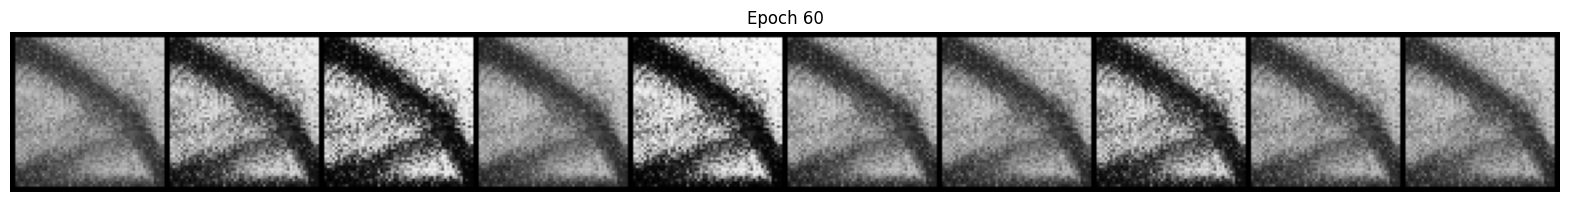

Epoch [61/200]  D Loss: 0.0171  G Loss: 5.1543
Epoch [62/200]  D Loss: 0.1708  G Loss: 4.8492
Epoch [63/200]  D Loss: 0.2003  G Loss: 6.4835
Epoch [64/200]  D Loss: 0.0470  G Loss: 3.9008
Epoch [65/200]  D Loss: 0.0150  G Loss: 4.0616
Epoch [66/200]  D Loss: 0.0218  G Loss: 4.9491
Epoch [67/200]  D Loss: 0.0420  G Loss: 4.3207
Epoch [68/200]  D Loss: 0.3191  G Loss: 6.7435
Epoch [69/200]  D Loss: 0.1009  G Loss: 4.1883
Epoch [70/200]  D Loss: 0.0436  G Loss: 4.2468
Epoch [71/200]  D Loss: 0.0732  G Loss: 3.7528
Epoch [72/200]  D Loss: 0.1417  G Loss: 2.7032
Epoch [73/200]  D Loss: 0.1545  G Loss: 6.1023
Epoch [74/200]  D Loss: 0.0937  G Loss: 4.9909
Epoch [75/200]  D Loss: 0.0117  G Loss: 9.4993
Epoch [76/200]  D Loss: 0.0338  G Loss: 4.3650
Epoch [77/200]  D Loss: 0.0095  G Loss: 7.2472
Epoch [78/200]  D Loss: 0.1423  G Loss: 3.7535
Epoch [79/200]  D Loss: 0.0536  G Loss: 6.4882
Epoch [80/200]  D Loss: 0.0028  G Loss: 5.8131


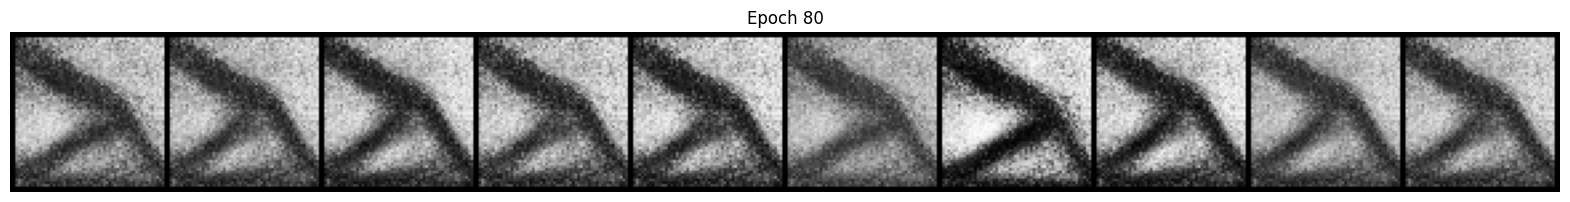

Epoch [81/200]  D Loss: 0.0266  G Loss: 7.4263
Epoch [82/200]  D Loss: 0.0165  G Loss: 4.8496
Epoch [83/200]  D Loss: 0.0156  G Loss: 5.6456
Epoch [84/200]  D Loss: 0.0124  G Loss: 5.1824
Epoch [85/200]  D Loss: 0.0212  G Loss: 9.8901
Epoch [86/200]  D Loss: 0.0652  G Loss: 3.6683
Epoch [87/200]  D Loss: 0.0903  G Loss: 3.5801
Epoch [88/200]  D Loss: 0.0222  G Loss: 10.0835
Epoch [89/200]  D Loss: 0.1446  G Loss: 4.0134
Epoch [90/200]  D Loss: 0.0531  G Loss: 4.0171
Epoch [91/200]  D Loss: 0.1891  G Loss: 7.8009
Epoch [92/200]  D Loss: 0.0114  G Loss: 4.9383
Epoch [93/200]  D Loss: 0.0787  G Loss: 10.8727
Epoch [94/200]  D Loss: 0.0375  G Loss: 5.2243
Epoch [95/200]  D Loss: 0.1614  G Loss: 2.9539
Epoch [96/200]  D Loss: 0.1323  G Loss: 4.9136
Epoch [97/200]  D Loss: 0.1482  G Loss: 4.2627
Epoch [98/200]  D Loss: 0.0351  G Loss: 6.0916
Epoch [99/200]  D Loss: 0.1082  G Loss: 2.6280
Epoch [100/200]  D Loss: 0.0398  G Loss: 4.5609


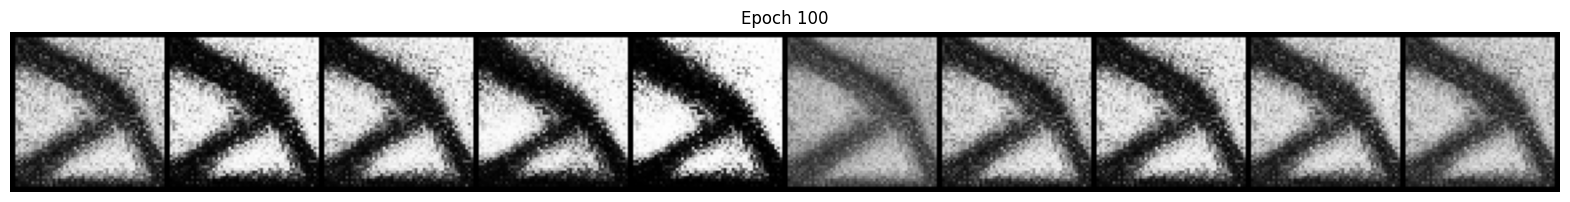

Epoch [101/200]  D Loss: 0.0085  G Loss: 6.4015
Epoch [102/200]  D Loss: 0.0167  G Loss: 4.5169
Epoch [103/200]  D Loss: 0.0400  G Loss: 3.9868
Epoch [104/200]  D Loss: 0.3319  G Loss: 7.3358
Epoch [105/200]  D Loss: 0.1153  G Loss: 3.2002
Epoch [106/200]  D Loss: 0.0430  G Loss: 3.7054
Epoch [107/200]  D Loss: 0.0527  G Loss: 4.4106
Epoch [108/200]  D Loss: 0.0860  G Loss: 5.9993
Epoch [109/200]  D Loss: 0.0117  G Loss: 6.7479
Epoch [110/200]  D Loss: 0.0773  G Loss: 3.7663
Epoch [111/200]  D Loss: 0.0859  G Loss: 4.3074
Epoch [112/200]  D Loss: 0.0716  G Loss: 4.9076
Epoch [113/200]  D Loss: 0.0353  G Loss: 5.8484
Epoch [114/200]  D Loss: 0.0277  G Loss: 5.1173
Epoch [115/200]  D Loss: 0.0117  G Loss: 5.4751
Epoch [116/200]  D Loss: 0.0361  G Loss: 4.4151
Epoch [117/200]  D Loss: 0.0048  G Loss: 5.7814
Epoch [118/200]  D Loss: 0.0267  G Loss: 4.5465
Epoch [119/200]  D Loss: 0.0862  G Loss: 4.0383
Epoch [120/200]  D Loss: 0.1486  G Loss: 3.8132


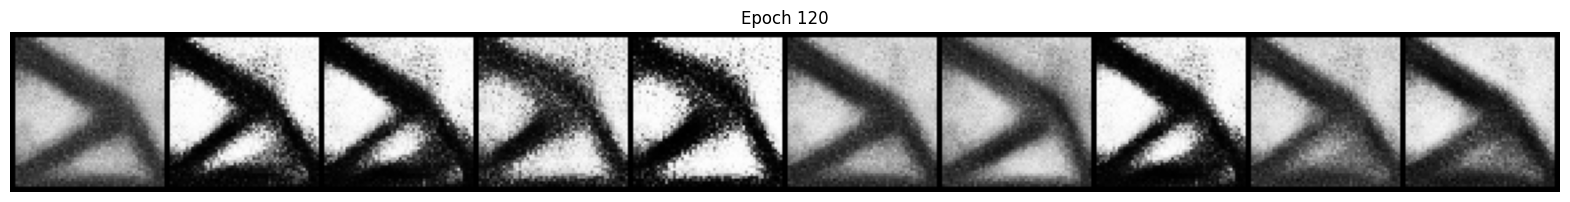

Epoch [121/200]  D Loss: 0.0812  G Loss: 3.0431
Epoch [122/200]  D Loss: 0.0365  G Loss: 3.6844
Epoch [123/200]  D Loss: 0.0990  G Loss: 3.0947
Epoch [124/200]  D Loss: 0.0974  G Loss: 2.7810
Epoch [125/200]  D Loss: 0.3902  G Loss: 4.6505
Epoch [126/200]  D Loss: 0.0691  G Loss: 2.9217
Epoch [127/200]  D Loss: 0.1356  G Loss: 3.5031
Epoch [128/200]  D Loss: 0.1530  G Loss: 2.1532
Epoch [129/200]  D Loss: 0.1298  G Loss: 5.6892
Epoch [130/200]  D Loss: 0.2011  G Loss: 5.0142
Epoch [131/200]  D Loss: 0.1331  G Loss: 3.1755
Epoch [132/200]  D Loss: 0.1981  G Loss: 4.4994
Epoch [133/200]  D Loss: 0.0228  G Loss: 5.4343
Epoch [134/200]  D Loss: 0.2356  G Loss: 2.2143
Epoch [135/200]  D Loss: 0.3781  G Loss: 2.0508
Epoch [136/200]  D Loss: 0.0994  G Loss: 6.5819
Epoch [137/200]  D Loss: 0.0944  G Loss: 3.1220
Epoch [138/200]  D Loss: 0.0176  G Loss: 4.9446
Epoch [139/200]  D Loss: 0.0861  G Loss: 3.8591
Epoch [140/200]  D Loss: 0.1904  G Loss: 3.5596


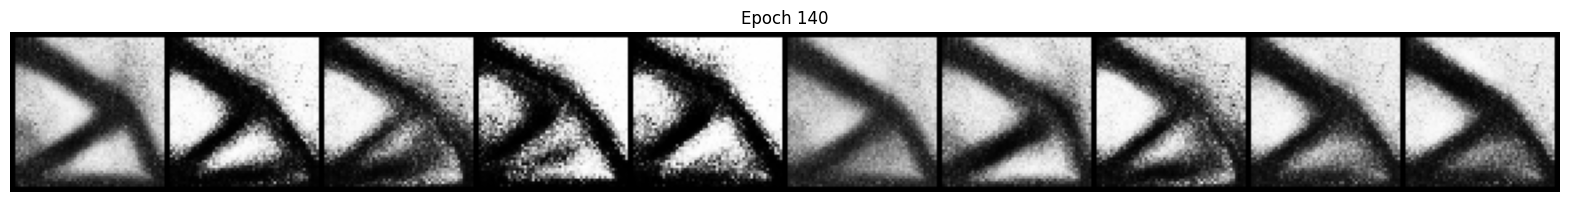

Epoch [141/200]  D Loss: 0.2233  G Loss: 2.4005
Epoch [142/200]  D Loss: 0.1911  G Loss: 4.2654
Epoch [143/200]  D Loss: 0.0328  G Loss: 4.8291
Epoch [144/200]  D Loss: 0.1060  G Loss: 3.2261
Epoch [145/200]  D Loss: 0.1508  G Loss: 3.7837
Epoch [146/200]  D Loss: 0.0518  G Loss: 3.6647
Epoch [147/200]  D Loss: 0.1537  G Loss: 3.4517
Epoch [148/200]  D Loss: 0.2244  G Loss: 1.9225
Epoch [149/200]  D Loss: 0.1150  G Loss: 5.3625
Epoch [150/200]  D Loss: 0.0652  G Loss: 4.2911
Epoch [151/200]  D Loss: 0.0501  G Loss: 3.9557
Epoch [152/200]  D Loss: 0.0574  G Loss: 4.6011
Epoch [153/200]  D Loss: 0.1124  G Loss: 2.7351
Epoch [154/200]  D Loss: 0.0669  G Loss: 5.0494
Epoch [155/200]  D Loss: 0.0532  G Loss: 5.1310
Epoch [156/200]  D Loss: 0.2765  G Loss: 2.8241
Epoch [157/200]  D Loss: 0.1814  G Loss: 4.2162
Epoch [158/200]  D Loss: 0.1642  G Loss: 2.4253
Epoch [159/200]  D Loss: 0.0350  G Loss: 4.6668
Epoch [160/200]  D Loss: 0.2295  G Loss: 3.5776


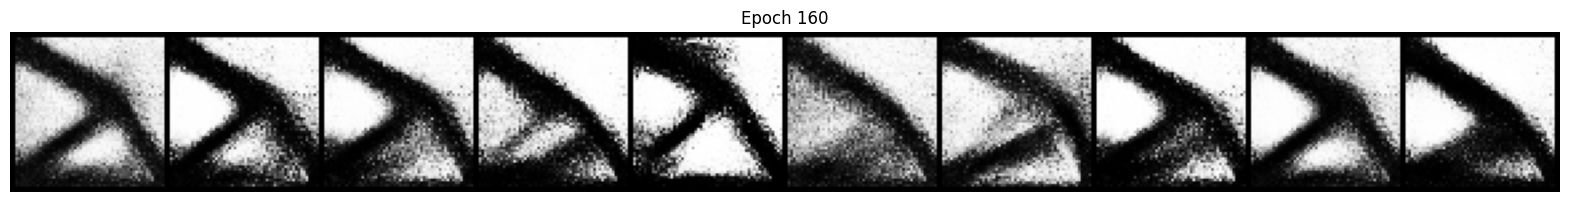

Epoch [161/200]  D Loss: 0.1606  G Loss: 2.7581
Epoch [162/200]  D Loss: 0.0905  G Loss: 3.7627
Epoch [163/200]  D Loss: 0.1224  G Loss: 4.1357
Epoch [164/200]  D Loss: 0.0775  G Loss: 3.7841
Epoch [165/200]  D Loss: 0.1219  G Loss: 2.8827
Epoch [166/200]  D Loss: 0.0891  G Loss: 5.2871
Epoch [167/200]  D Loss: 0.1112  G Loss: 5.0515
Epoch [168/200]  D Loss: 0.2033  G Loss: 4.9121
Epoch [169/200]  D Loss: 0.0662  G Loss: 5.0762
Epoch [170/200]  D Loss: 0.0706  G Loss: 4.6801
Epoch [171/200]  D Loss: 0.0362  G Loss: 4.8812
Epoch [172/200]  D Loss: 0.2459  G Loss: 2.9217
Epoch [173/200]  D Loss: 0.1037  G Loss: 4.4630
Epoch [174/200]  D Loss: 0.0989  G Loss: 5.7549
Epoch [175/200]  D Loss: 0.2349  G Loss: 5.1540
Epoch [176/200]  D Loss: 0.2224  G Loss: 3.3128
Epoch [177/200]  D Loss: 0.0486  G Loss: 6.5702
Epoch [178/200]  D Loss: 0.0600  G Loss: 4.8917
Epoch [179/200]  D Loss: 0.1207  G Loss: 3.4694
Epoch [180/200]  D Loss: 0.1143  G Loss: 3.2669


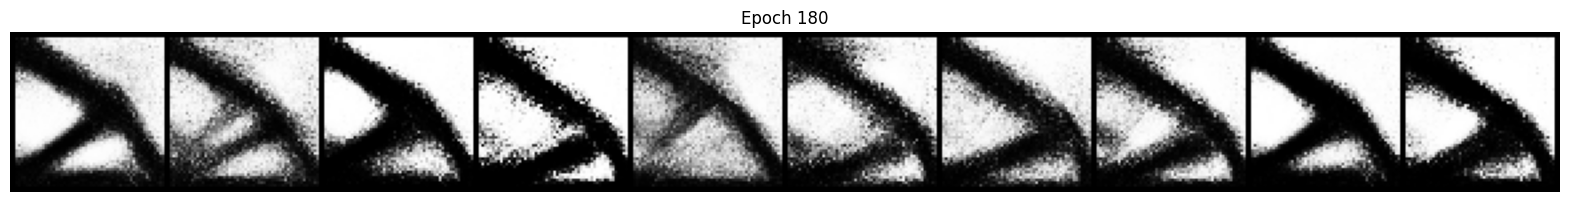

Epoch [181/200]  D Loss: 0.2294  G Loss: 4.3353
Epoch [182/200]  D Loss: 0.1421  G Loss: 2.8835
Epoch [183/200]  D Loss: 0.0861  G Loss: 3.5535
Epoch [184/200]  D Loss: 0.1819  G Loss: 4.7020
Epoch [185/200]  D Loss: 0.1972  G Loss: 4.3698
Epoch [186/200]  D Loss: 0.0494  G Loss: 5.5129
Epoch [187/200]  D Loss: 0.0770  G Loss: 3.9335
Epoch [188/200]  D Loss: 0.1151  G Loss: 3.5648
Epoch [189/200]  D Loss: 0.1623  G Loss: 4.0883
Epoch [190/200]  D Loss: 0.1791  G Loss: 2.9962
Epoch [191/200]  D Loss: 0.0933  G Loss: 5.8956
Epoch [192/200]  D Loss: 0.1488  G Loss: 3.0289
Epoch [193/200]  D Loss: 0.0708  G Loss: 3.6126
Epoch [194/200]  D Loss: 0.1601  G Loss: 3.4239
Epoch [195/200]  D Loss: 0.0950  G Loss: 4.1018
Epoch [196/200]  D Loss: 0.1138  G Loss: 3.4760
Epoch [197/200]  D Loss: 0.2153  G Loss: 2.6674
Epoch [198/200]  D Loss: 0.2671  G Loss: 2.8320
Epoch [199/200]  D Loss: 0.1583  G Loss: 2.4995
Epoch [200/200]  D Loss: 0.2526  G Loss: 2.0760


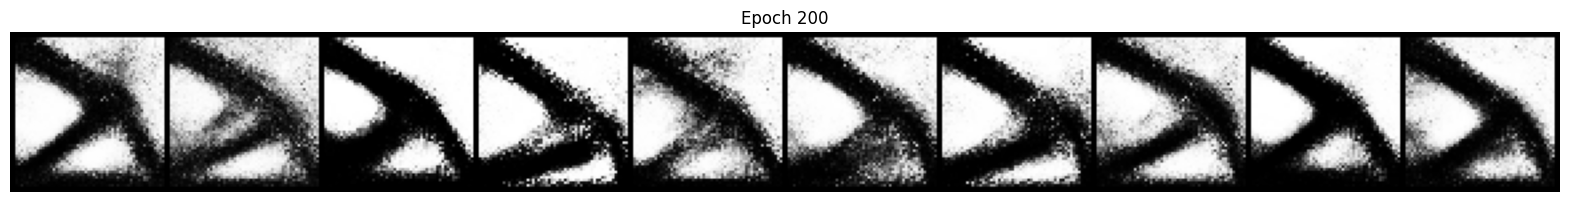

In [11]:
"""
Training part
"""
for epoch in range(1, num_epoch + 1):

    for i, (images) in enumerate(train_loader):

        # make ground truth (labels) -> [1 / Real] & [0 / Fake]
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

        # reshape real images --> flatten to (batch_size, 56*56)
        real_images = images[0].reshape(batch_size, -1)  # flatten image to (batch_size, 56*56)

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # initialize gradient -> initialize generator model gradient to 0
        g_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        # compare result of discriminator with fake images & real labels
        # if generator deceives discriminator, g_loss will decrease
        g_loss = criterion(discriminator(fake_images), real_label)

        # train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # initialize gradient -> initialize discriminator model gradient to 0
        d_optimizer.zero_grad()

        # calculate fake & real loss with generated images above & real images
        fake_loss = criterion(discriminator(fake_images.detach()), fake_label)
        real_loss = criterion(discriminator(real_images), real_label)
        d_loss = (fake_loss + real_loss)/2

        # train discriminator with backpropagation
        d_loss.backward()
        d_optimizer.step()

    # print losses at the end of each epoch
    print(f"Epoch [{epoch}/{num_epoch}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

    # save and visualize generated images at specific intervals
    if epoch % 20 == 0 or epoch == 1:
        with torch.no_grad():
            # generate fake images with fixed noise
            fake_images = generator(fixed_noise).detach().cpu()
        fake_images = fake_images.view(-1, 1, 56, 56)

        # save images as a grid using save_image
        save_image(fake_images, f"./GAN_samples/GAN_epoch_{epoch}.png", nrow=10, normalize=True)

        # display the generated images
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./GAN_samples/GAN_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

        # optionally, save model checkpoints
        if epoch % 50 == 0 or epoch == num_epoch:
            torch.save(generator.state_dict(), f"./GAN_samples/generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"./GAN_samples/discriminator_epoch_{epoch}.pth")



## 8. Load & Evaluate model

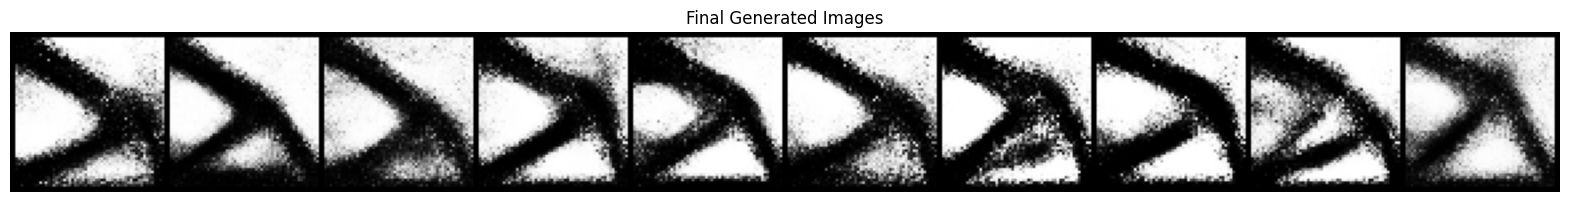

In [12]:
# final Image Generation and Visualization after training
with torch.no_grad():
    final_noise = torch.randn(10, noise_size).to(device)
    final_fake_images = generator(final_noise).cpu()
    final_fake_images = final_fake_images.view(-1, 1, 56, 56)
    save_image(final_fake_images, f"./GAN_samples/GAN_final.png", nrow=10, normalize=True)

# display the final generated images
plt.figure(figsize=(20, 4))
img = plt.imread("./GAN_samples/GAN_final.png")
plt.imshow(img)
plt.title("Final Generated Images")
plt.axis('off')
plt.show()